In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sys
from scipy import stats

In [3]:
import json
plt_properties = json.load(open('utils/plt_properties.json'))
fig_width = plt_properties['fig_width']
plt.rcParams.update(plt_properties['plt_params'])

In [4]:
sys.path.append(os.path.join(os.getcwd(), 'utils'))
from quartiles import quartiles_confusion_plot, rank_rank_plot
from variables import min_pred_col, vol_pred_col, min_pred_col_day, vol_pred_col_day, target_col

# 5) Interindividual differences

In [5]:
df = pd.read_csv('../Data/dataset_mlr.csv')

/tmp/ipykernel_69757/900100850.py:1: DtypeWarning: Columns (12,22,23,24,25,35,36,37,38,39,44,48,49,53,54,55,61,72,76,121,122,124,125,127,136,138,139,140,141,142,143,144,152,157,158,159,161,162,163,210,216,218,219,221,233,251,252,254,503,509,511,513,515,519,523,525,527,529) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Data/dataset_mlr.csv')


## 5.1) Quartile confusion matrices

/tmp/ipykernel_69757/2665646662.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cv_split"] = np.nan


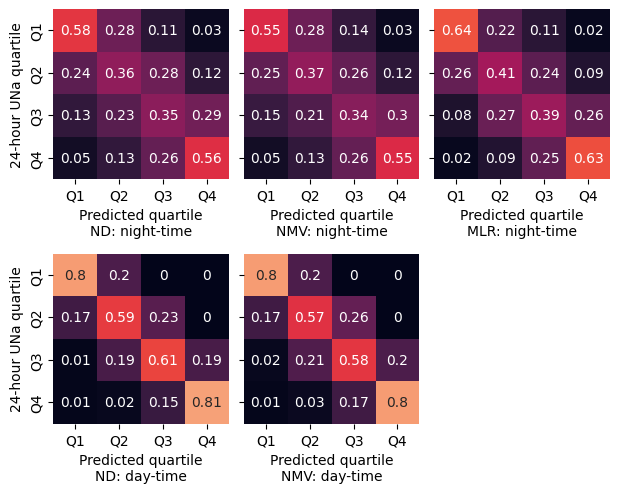

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(fig_width, 0.8 * fig_width), sharey=True)

quartiles_confusion_plot(df[target_col], df[min_pred_col], ax=ax[0, 0], round_=2)
quartiles_confusion_plot(df[target_col], df[min_pred_col_day], ax=ax[1, 0], round_=2)
quartiles_confusion_plot(df[target_col], df[vol_pred_col], ax=ax[0, 1], round_=2)
quartiles_confusion_plot(df[target_col], df[vol_pred_col_day], ax=ax[1, 1], round_=2)

# Hack to avoid re-running code: re-create splits
data = df[df.mlr_preds.notna()]
data["cv_split"] = np.nan
ind = list(set(df['sk1_id'].values))
random.Random(4).shuffle(ind)
cv = 5
for i in range(cv):
    subset = ind[int((i * len(ind)) / cv) : int(((i+1) * len(ind)) / cv)]
    subset_id = data[data['sk1_id'].isin(subset)].index
    data.loc[subset_id, 'cv_split'] = i
quartiles_confusion_plot(data[target_col], data.mlr_preds, splits=data["cv_split"], ax=ax[0, 2], round_=2)

ax[0, 0].set_ylabel('24-hour UNa quartile')
ax[0, 0].set_xlabel('Predicted quartile\nND: night-time')
ax[1, 0].set_xlabel('Predicted quartile\nND: day-time')
ax[1, 0].set_ylabel('24-hour UNa quartile')
ax[0, 1].set_xlabel('Predicted quartile\nNMV: night-time')
ax[1, 1].set_xlabel('Predicted quartile\nNMV: day-time')
ax[0, 2].set_xlabel('Predicted quartile\nMLR: night-time')
ax[1, 2].axis('off')
fig.tight_layout()
fig.savefig('../Figures/distributions/quartiles_confusion.png', dpi=500)

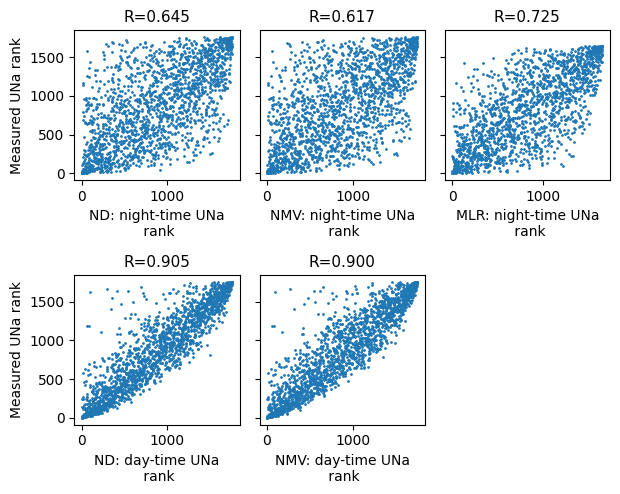

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(fig_width, 0.8 * fig_width), sharey=True)

rank_rank_plot(df[target_col], df[min_pred_col], ax=ax[0, 0])
rank_rank_plot(df[target_col], df[min_pred_col_day], ax=ax[1, 0])
rank_rank_plot(df[target_col], df[vol_pred_col], ax=ax[0, 1])
rank_rank_plot(df[target_col], df[vol_pred_col_day], ax=ax[1, 1])
x = df[~(df.mlr_preds.isna())][target_col]
y = df[~(df.mlr_preds.isna())].mlr_preds
rank_rank_plot(x, y, ax=ax[0, 2])

spearman_r = stats.spearmanr(df[target_col], df[min_pred_col]).correlation
ax[0, 0].set(xlabel='ND: night-time UNa\n rank', ylabel='Measured UNa rank', title=f"R={spearman_r:.3f}")
spearman_r = stats.spearmanr(df[target_col], df[min_pred_col_day]).correlation
ax[1, 0].set(xlabel='ND: day-time UNa\n rank', ylabel='Measured UNa rank', title=f"R={spearman_r:.3f}")
spearman_r = stats.spearmanr(df[target_col], df[vol_pred_col]).correlation
ax[0, 1].set(xlabel='NMV: night-time UNa\n rank', title=f"R={spearman_r:.3f}")
spearman_r = stats.spearmanr(df[target_col], df[vol_pred_col_day]).correlation
ax[1, 1].set(xlabel='NMV: day-time UNa\n rank', title=f"R={spearman_r:.3f}")
spearman_r = stats.spearmanr(x, y).correlation
ax[0, 2].set(xlabel='MLR: night-time UNa\n rank', title=f"R={spearman_r:.3f}")
ax[1, 2].axis('off')
fig.tight_layout()
fig.savefig('../Figures/distributions/scatter.png', dpi=500)

## 5.2) Root-mean-square error

In [8]:
rmse_vol = np.mean((df[target_col] - df[vol_pred_col]) ** 2) ** 0.5
print(rmse_vol)
rmse_min = np.mean((df[target_col] - df[min_pred_col]) ** 2) ** 0.5
print(rmse_min)

67.6298945762832
64.35423136308061
